In [1]:
from dotenv import load_dotenv
load_dotenv(".env", override=True)
%load_ext autoreload
%autoreload 2

# Deepagent for Research

We will use the `deepagents` package to create a research agent. When using the `deepagents` package, it's important to: 

1. Understand the native tools available
2. Supply task-specific tools
3. Supply task-specific instructions
4. Supply task-specific sub-agents

## Task-Specific Tools 

You can see an overview of the native tools in the [deepagents package README](https://github.com/langchain-ai/deepagents?tab=readme-ov-file#model) as well as the [quickstarts README](https://github.com/langchain-ai/deepagents-quickstarts). We'll extend this with two task-specific tools. 

### Search Tool 

There are different search tools that we can use. For example, we can use [Tavily](https://www.tavily.com/) to search for relevant URLs, then fetches the full webpage content.

### Think Tool 

We'll supply a [think tool](https://www.anthropic.com/engineering/claude-think-tool), which is a useful way to help audit agent decision making. 

In [2]:
from research_agent.tools import tavily_search, think_tool, contextual_search
tools = [tavily_search, think_tool, contextual_search]

In [3]:
# Test contextual_search tool
print("Testing contextual_search tool...")
print("=" * 80)

# Test with a sample query (adjust based on your knowledge base)
test_query = "what is microsofts revenue?"
print(f"\nQuery: {test_query}\n")

try:
    result = contextual_search.invoke({"query": test_query, "max_results": 5})
    print(result)
    print("\n" + "=" * 80)
    print("✅ contextual_search tool is working!")
except Exception as e:
    print(f"\n❌ Error testing contextual_search: {e}")
    print("\nMake sure you have:")
    print("1. CONTEXTUAL_AI_API_KEY set in your .env file")
    print("2. CONTEXTUAL_AI_AGENT_ID set in your .env file")
    print("3. The 'contextual' package installed: pip install contextual")


Testing contextual_search tool...

Query: what is microsofts revenue?

🔍 Found 5 result(s) for 'what is microsofts revenue?' in ContextualAI knowledge base:

## msft_10q_fy2024q1
**Attribution:** Context ID: 90257057-e8c4-befe-aeaf-dd477d3c9ba3 | Doc ID: a178298f-e14b-49bc-94af-42cc2a188699 | Page: 32 | Score: 0.9829

Filename: Microsoft 10-Q FY2024 Q1
Section: PART I
Sub-Section: ITEM 2. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL  CONDITION AND RESUL TS OF OPERATIONS
Sub-Sub-Section: OVERVIEW
Microsoft is a technology company whose mission is to empower every person and every organization on  the planet to achieve more. We strive to create local opportunity, growth, and impact in every country  around the world. We are creating the platforms and tools, powered by artificial intelligence (“AI”), that  deliver better, faster, and more effective solutions to support small and large business competitiveness,  improve educational and health outcomes, grow public-sector efficiency, a

In [13]:
# Optional: Inspect raw ContextualAI response structure
# This helps you understand what data is available
import os
from contextual import ContextualAI

api_key = os.getenv("CONTEXTUAL_AI_API_KEY")
agent_id = os.getenv("CONTEXTUAL_AI_AGENT_ID")

if api_key and agent_id:
    client = ContextualAI(api_key=api_key)
    
    # Get raw response WITH content text included
    query_result = client.agents.query.create(
        agent_id=agent_id,
        messages=[{"content": "what is microsofts revenue?", "role": "user"}],
        retrievals_only=True,
        include_retrieval_content_text=True  # This is the key parameter!
    )
    
    print("Raw QueryResponse structure:")
    print(f"Conversation ID: {query_result.conversation_id}")
    print(f"Number of retrieval contents: {len(query_result.retrieval_contents)}")
    print("\n" + "=" * 80)
    
    # Show first result details
    if query_result.retrieval_contents:
        first_result = query_result.retrieval_contents[0]
        print("\nFirst result structure:")
        print(f"  - doc_name: {getattr(first_result, 'doc_name', 'N/A')}")
        print(f"  - content_id: {getattr(first_result, 'content_id', 'N/A')}")
        print(f"  - doc_id: {getattr(first_result, 'doc_id', 'N/A')}")
        print(f"  - page: {getattr(first_result, 'page', 'N/A')}")
        print(f"  - format: {getattr(first_result, 'format', 'N/A')}")
        print(f"  - score: {getattr(first_result, 'score', 'N/A')}")
        print(f"  - content_text available: {getattr(first_result, 'content_text', None) is not None}")
        if hasattr(first_result, 'content_text') and first_result.content_text:
            print(f"\n  - content_text preview (first 300 chars):")
            print(f"    {first_result.content_text[:300]}...")
        else:
            print(f"\n  ⚠️  content_text is None or empty")
            print(f"  Make sure you're using include_retrieval_content_text=True in the query!")
else:
    print("⚠️  ContextualAI credentials not found. Skipping raw response inspection.")


Raw QueryResponse structure:
Conversation ID: 74b9ae2f-9f61-487b-a8a5-51fde594545e
Number of retrieval contents: 15


First result structure:
  - doc_name: msft_10q_fy2024q1
  - content_id: 90257057-e8c4-befe-aeaf-dd477d3c9ba3
  - doc_id: a178298f-e14b-49bc-94af-42cc2a188699
  - page: 32
  - format: pdf
  - score: 0.9829475932644243
  - content_text available: True

  - content_text preview (first 300 chars):
    Filename: Microsoft 10-Q FY2024 Q1
Section: PART I
Sub-Section: ITEM 2. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL  CONDITION AND RESUL TS OF OPERATIONS
Sub-Sub-Section: OVERVIEW
Microsoft is a technology company whose mission is to empower every person and every organization on  the planet t...


## Task-Specific Instructions
 
Next, let's define task specific instructions using [a few prompting techniques for agents](https://youtu.be/XSZP9GhhuAc?si=zowpViL-2j-vI9hA):

### 1. Think Like The Agent
What instructions would you give a new work colleague?
- **Read the question carefully** - What specific information does the user need?
- **Start with broader searches** - Use broad, comprehensive queries first
- **After each search, pause and assess** - Do I have enough to answer? What's still missing?
- **Execute narrower searches as you gather information** - Fill in the gaps.

### 2. Concrete Heuristics (Prevent "Spin-Out" on excessive tool calls)
Use **Hard Limits** to prevent the research agent from calling tools excessively:
- **Stop when you can answer confidently** - Don't keep searching for perfection.
- **Give it budgets** - Use 2-3 search tool calls for simple queries. Use up to 5 for complex queries.
- **Limit** - Always stop after 5 search tool calls if you cannot find the right source(s).

### 3. Show your thinking
After each search tool calling, use [`think_tool` to analyze the results](https://www.anthropic.com/engineering/claude-think-tool):
- What key information did I find? 
- What's missing?
- Do I have enough to answer the question comprehensively?
- Should I search more or provide my answer?

In [5]:
from datetime import datetime
from utils import show_prompt, format_messages
from research_agent.prompts import (
    RESEARCHER_INSTRUCTIONS,
    RESEARCH_WORKFLOW_INSTRUCTIONS,
    SUBAGENT_DELEGATION_INSTRUCTIONS,
)

In [6]:
show_prompt(RESEARCHER_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the research tools provided to you to find resources that can help answer the research      │
│  question.                                                                                                      │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Research Tools>                                                                                     │
│  You have access to two specific research tools:                                                                │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Research Tools>                                                                                    │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Complex queries**: Use up to 5 search tool calls maximum                                                   │
│  - **Always stop**: After 5 search tool calls if you cannot find the right sources                              │
│                                                       

## Task-Specific Sub-Agents

You can specify [custom subagents](https://github.com/langchain-ai/deepagents?tab=readme-ov-file#subagents) as a means of context isolation. 

Here's well define a sub-agent that can search the web for information. 

In [14]:
# Get current date
current_date = datetime.now().strftime("%Y-%m-%d")

# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "system_prompt": RESEARCHER_INSTRUCTIONS.format(date=current_date),
    "tools": [tavily_search, think_tool],
}

## Putting it all together

### Instructions

Now, we can look at all of our instructions together. 

In [15]:
# Limits
max_concurrent_research_units = 2
max_researcher_iterations = 2

# Combine orchestrator instructions (RESEARCHER_INSTRUCTIONS only for sub-agents)
INSTRUCTIONS = (
    RESEARCH_WORKFLOW_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    +  SUBAGENT_DELEGATION_INSTRUCTIONS.format(
        max_concurrent_research_units=max_concurrent_research_units,
        max_researcher_iterations=max_researcher_iterations,
    )
)

show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # Research Workflow                                                                                            │
│                                                                                                                 │
│  Follow this workflow for all research requests:                                                                │
│                                                                                                                 │
│  1. **Plan**: Create a todo list with write_todos to break down the research into focused tasks                 │
│  2. **Save the request**: Use write_file() to save the user's research question to `/research_request.md`       │
│  3. **Research**: Delegate research tasks to sub-agents using the task() tool - ALWAYS use sub-agents for       │
│  research, never conduct research yourself                                                                      │
│  4. **Synthesize**: Review all sub-agent findings and consolidate citations (each unique URL gets one number    │
│  across all findings)                                                                                           │
│  5. **Write Report**: Write a comprehensive final report to `/final_report.md` (see Report Writing Guidelines   │
│  below)                                                                                                         │
│  6. **Verify**: Read `/research_request.md` and confirm you've addressed all aspects with proper citations and  │
│  structure                                                                                                      │
│                                                                                                                 │
│  ## Research Planning Guidelines                                                                                │
│  - Batch similar research tasks into a single TODO to minimize overhead                                         │
│  - For simple fact-finding questions, use 1 sub-agent                                                           │
│  - For comparisons or multi-faceted topics, delegate to multiple parallel sub-agents                            │
│  - Each sub-agent should research one specific aspect and return findings                                       │
│                                                                                                                 │
│  ## Report Writing Guidelines                                                                                   │
│                                                                                                                 │
│  When writing the final report to `/final_report.md`, follow these structure patterns:                          │
│                                                                                                                 │
│  **For comparisons:**                                                                                           │
│  1. Introduction                                                                                                │
│  2. Overview of topic A                                                                                         │
│  3. Overview of topic B                                                                                         │
│  4. Detailed comparison                                                                                         │
│  5. Conclusion                                                                                                  │
│                                                                                                                 │
│  **For lists/rankings:**                              

### Create the agent

Now, we create our deepagent with these components. 

In [16]:
from IPython.display import Image, display
from deepagents import create_deep_agent
from langchain.chat_models import init_chat_model
#from langchain_google_genai import ChatGoogleGenerativeAI

# Model Gemini 3 
#model = ChatGoogleGenerativeAI(model="gemini-3-pro-preview")

# Model Claude 4.5
model = init_chat_model(model="anthropic:claude-sonnet-4-5-20250929", temperature=0.0)

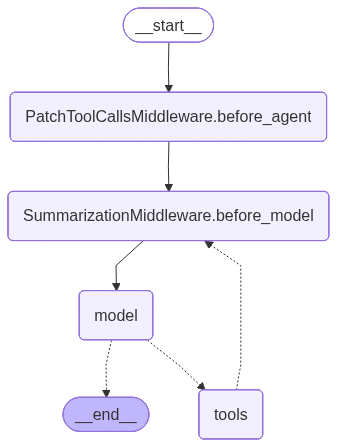

In [17]:
# Create the agent
agent = create_deep_agent(
      model=model,
      tools=tools, 
      system_prompt=INSTRUCTIONS,
      subagents=[research_sub_agent],
  )
  
# Show the agent
display(Image(agent.get_graph().draw_mermaid_png()))

In [18]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "research microsofts revenue",
            }
        ],
    }, 
)
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ research microsofts revenue                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll research Microsoft's revenue for you. Let me start by organizing this task and gathering comprehensive     │
│ information.                                                                                                    │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save the research request to /research_request.md",                                           │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate research on Microsoft's revenue to a sub-agent",                                     │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize findings and write comprehensive report to /final_report.md",                      │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify report addresses all aspects of the request",                                          │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01X5QttqQ4twjG8SgE6hi9Jy                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save the research request to /research_request.md', 'status':                │
│ 'in_progress'}, {'content': "Delegate research on Microsoft's revenue to a sub-agent", 'status': 'pending'},    │
│ {'content': 'Synthesize findings and write comprehensive report to /final_report.md', 'status': 'pending'},     │
│ {'content': 'Verify report addresses all aspects of the request', 'status': 'pending'}]                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "/research_request.md",                                                                          │
│   "content": "# Research Request\n\nResearch Microsoft's revenue\n\n## Key Areas to Cover:\n- Current revenue   │
│ figures\n- Recent financial performance\n- Revenue trends over time\n- Revenue breakdown by business            │
│ segments\n- Year-over-year growth\n"                                                                            │
│ }                                                                                                               │
│    ID: toolu_01FtE8KHWPvXYovAvCjyhHcK                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file /research_request.md                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save the research request to /research_request.md",                                           │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate research on Microsoft's revenue to a sub-agent",                                     │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize findings and write comprehensive report to /final_report.md",                      │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify report addresses all aspects of the request",                                          │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01NaatSms58ia8gTU6PjMzxj                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save the research request to /research_request.md', 'status': 'completed'},  │
│ {'content': "Delegate research on Microsoft's revenue to a sub-agent", 'status': 'in_progress'}, {'content':    │
│ 'Synthesize findings and write comprehensive report to /final_report.md', 'status': 'pending'}, {'content':     │
│ 'Verify report addresses all aspects of the request', 'status': 'pending'}]                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "research-agent",                                                                            │
│   "description": "Research Microsoft's revenue comprehensively. I need you to find and return:\n\n1. **Latest   │
│ revenue figures**: Most recent quarterly and annual revenue numbers\n2. **Recent financial performance**:       │
│ Latest fiscal year results and trends\n3. **Revenue breakdown**: Revenue by business segments (Intelligent      │
│ Cloud, Productivity & Business Processes, More Personal Computing, etc.)\n4. **Historical trends**: Revenue     │
│ growth over the past 3-5 years\n5. **Year-over-year growth rates**: Percentage changes and growth trends\n6.    │
│ **Key revenue drivers**: What products/services are driving revenue growth\n\nFor each piece of information,    │
│ provide:\n- The specific numbers/data\n- The time period it covers\n- The source URL where you found            │
│ it\n\nReturn your findings in a structured format with clear sections and include all source URLs for citation  │
│ purposes."                                                                                                      │
│ }                                                                                                               │
│    ID: toolu_01UpD63xRL7cdVptzUHKyXqv                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Based on my comprehensive research, here are Microsoft's revenue findings:                                      │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ ## 1. Latest Revenue Figures                                                                                    │
│                                                                                                                 │
│ ### Most Recent Quarter - Q1 FY2025 (ended September 30, 2024)                                                  │
│ - **Total Revenue**: $65.59 billion                                                                             │
│ - **Year-over-Year Growth**: 16% (from $56.52 billion in Q1 FY2024)                                             │
│ - **Net Income**: $24.67 billion (10.6% increase YoY)                                                           │
│ - **Diluted EPS**: $3.30 (compared to $2.99 in Q1 FY2024)                                                       │
│                                                                                                                 │
│ **Time Period**: Quarter ended September 30, 2024 [1][2]                                                        │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ ## 2. Recent Financial Performance - Fiscal Year 2024                                                           │
│                                                                                                                 │
│ ### Annual Results (FY2024 ended June 30, 2024)                                                                 │
│ - **Total Revenue**: $245.122 billion                                                                           │
│ - **Year-over-Year Growth**: 15.67% (from $211.915 billion in FY2023)                                           │
│ - **Net Income**: $88.1 billion (22% increase YoY)                                                              │
│                                                                                                                 │
│ **Time Period**: Fiscal year ended June 30, 2024 [3][4]                                                         │
│                                                                                                                 │
│ ### Quarterly Progression in FY2024                                                                             │
│ - **Q4 FY2024** (June 30, 2024): $64.727 billion                                                                │
│ - **Q3 FY2024** (March 31, 2024): $61.858 billion                                                               │
│ - **Q2 FY2024** (December 31, 2023): $62.020 billion                                                            │
│ - **Q1 FY2024** (September 30, 2023): $56.517 billion                                                           │
│                                                                                                                 │
│ **Time Period**: Fiscal year 2024 quarters [4]                                                                  │
│                                                                                                                 │
│ ---                                                    

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save the research request to /research_request.md",                                           │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate research on Microsoft's revenue to a sub-agent",                                     │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize findings and write comprehensive report to /final_report.md",                      │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify report addresses all aspects of the request",                                          │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01E7CaZVbx7k3XHsRT6DathB                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save the research request to /research_request.md', 'status': 'completed'},  │
│ {'content': "Delegate research on Microsoft's revenue to a sub-agent", 'status': 'completed'}, {'content':      │
│ 'Synthesize findings and write comprehensive report to /final_report.md', 'status': 'in_progress'}, {'content': │
│ 'Verify report addresses all aspects of the request', 'status': 'pending'}]                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "/final_report.md",                                                                              │
│   "content": "# Microsoft Revenue Research Report\n\n## Overview\n\nMicrosoft has demonstrated exceptional      │
│ financial performance with strong revenue growth driven by cloud computing, artificial intelligence, and        │
│ enterprise software services. As of the most recent quarter (Q1 FY2025 ended September 30, 2024), Microsoft     │
│ reported total revenue of $65.59 billion, representing a 16% year-over-year increase [1]. The company's fiscal  │
│ year 2024 revenue reached $245.122 billion, marking a 15.67% increase from the previous year [2].\n\n## Latest  │
│ Financial Performance\n\n### Q1 FY2025 Results (September 30, 2024)\n\nMicrosoft's first quarter of fiscal year │
│ 2025 showcased robust growth across all business segments. Total revenue reached $65.59 billion, up 16% from    │
│ $56.52 billion in the same quarter of the previous year [1]. Net income for the quarter was $24.67 billion,     │
│ representing a 10.6% increase year-over-year, with diluted earnings per share of $3.30 compared to $2.99 in Q1  │
│ FY2024 [1].\n\nThe company's gross margin stood at 69%, down one percentage point due to scaling of AI          │
│ infrastructure investments. Operating margin remained strong at 47%, demonstrating operational efficiency       │
│ despite significant capital expenditures [5]. Cash flow from operations reached $34.2 billion, up 12%           │
│ year-over-year, reflecting the company's strong cash generation capabilities [5].\n\n### Fiscal Year 2024       │
│ Annual Results\n\nFor the full fiscal year 2024 (ended June 30, 2024), Microsoft achieved total revenue of      │
│ $245.122 billion, representing a 15.67% increase from $211.915 billion in FY2023 [2][3]. Net income for the     │
│ year was $88.1 billion, a 22% increase year-over-year, demonstrating strong profitability growth that outpaced  │
│ revenue growth [2].\n\nThe fiscal year showed consistent quarterly progression with Q4 FY2024 generating        │
│ $64.727 billion, Q3 generating $61.858 billion, Q2 generating $62.020 billion, and Q1 generating $56.517        │
│ billion [3]. This steady quarterly performance reflects the company's diversified revenue streams and strong    │
│ market position across multiple product categories.\n\n## Revenue by Business Segment\n\nMicrosoft organizes    │
│ its business into three primary segments: Productivity and Business Processes, Intelligent Cloud, and More      │
│ Personal Computing. Each segment has shown distinct growth patterns and contributes differently to the          │
│ company's overall revenue.\n\n### Productivity and Business Processes\n\nThe Productivity and Business          │
│ Processes segment generated $28.32 billion in Q1 FY2025, representing 43.3% of total company revenue and        │
│ growing 12% year-over-year from $25.25 billion in Q1 FY2024 [1][5]. Operating income for this segment reached   │
│ $16.52 billion, growing 16% year-over-year [1].\n\nMicrosoft 365 Commercial Cloud revenue grew 15% (16% in      │
│ constant currency) with paid seats increasing 8% year-over-year [5]. The growth was driven by E5 license        │
│ adoption and the introduction of Microsoft 365 Copilot, which has achieved the fastest adoption rate of any new │
│ Microsoft 365 suite. Nearly 70% of Fortune 500 companies now use Microsoft 365 Copilot, with daily active users │
│ more than doubling quarter-over-quarter [5].\n\nDynamics

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file /final_report.md                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save the research request to /research_request.md",                                           │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate research on Microsoft's revenue to a sub-agent",                                     │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize findings and write comprehensive report to /final_report.md",                      │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify report addresses all aspects of the request",                                          │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01TxQcYoRsoYUXEZMJjsXsSZ                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save the research request to /research_request.md', 'status': 'completed'},  │
│ {'content': "Delegate research on Microsoft's revenue to a sub-agent", 'status': 'completed'}, {'content':      │
│ 'Synthesize findings and write comprehensive report to /final_report.md', 'status': 'completed'}, {'content':   │
│ 'Verify report addresses all aspects of the request', 'status': 'in_progress'}]                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "/research_request.md"                                                                           │
│ }                                                                                                               │
│    ID: toolu_01GaRSHqqfTCo7bfsewhZcP7                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1  # Research Request                                                                                      │
│      2                                                                                                          │
│      3  Research Microsoft's revenue                                                                            │
│      4                                                                                                          │
│      5  ## Key Areas to Cover:                                                                                  │
│      6  - Current revenue figures                                                                               │
│      7  - Recent financial performance                                                                          │
│      8  - Revenue trends over time                                                                              │
│      9  - Revenue breakdown by business segments                                                                │
│     10  - Year-over-year growth                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save the research request to /research_request.md",                                           │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate research on Microsoft's revenue to a sub-agent",                                     │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize findings and write comprehensive report to /final_report.md",                      │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify report addresses all aspects of the request",                                          │
│       "status": "completed"                                                                                     │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01WSA6XjWzAzAUm6hhxqqYox                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save the research request to /research_request.md', 'status': 'completed'},  │
│ {'content': "Delegate research on Microsoft's revenue to a sub-agent", 'status': 'completed'}, {'content':      │
│ 'Synthesize findings and write comprehensive report to /final_report.md', 'status': 'completed'}, {'content':   │
│ 'Verify report addresses all aspects of the request', 'status': 'completed'}]                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I've completed comprehensive research on Microsoft's revenue. Here are the key findings:                        │
│                                                                                                                 │
│ ## Summary                                                                                                      │
│                                                                                                                 │
│ **Latest Revenue (Q1 FY2025 - Sept 30, 2024):**                                                                 │
│ - Total revenue: **$65.59 billion** (16% YoY growth)                                                            │
│ - Net income: $24.67 billion                                                                                    │
│ - Microsoft Cloud revenue: $38.9 billion (22% YoY growth)                                                       │
│                                                                                                                 │
│ **Fiscal Year 2024 (ended June 30, 2024):**                                                                     │
│ - Annual revenue: **$245.122 billion** (15.67% YoY growth)                                                      │
│ - Net income: $88.1 billion (22% increase)                                                                      │
│                                                                                                                 │
│ **Revenue by Business Segment (Q1 FY2025):**                                                                    │
│ 1. **Productivity & Business Processes**: $28.32B (43.3% of total, +12% YoY)                                    │
│    - Microsoft 365, Dynamics 365, LinkedIn                                                                      │
│ 2. **Intelligent Cloud**: $24.09B (36.7% of total, +20% YoY)                                                    │
│    - Azure growing 33%, AI contributing 12 percentage points                                                    │
│ 3. **More Personal Computing**: $13.18B (20.1% of total, +17% YoY)                                              │
│    - Gaming up 43% (driven by Activision acquisition)                                                           │
│                                                                                                                 │
│ **5-Year Growth:**                                                                                              │
│ - Revenue grew from $143B (FY2020) to $282B (TTM FY2025)                                                        │
│ - 97% total growth with ~14.5% CAGR                                                                             │
│                                                                                                                 │
│ **Key Revenue Drivers:**                                                                                        │
│ - **AI**: Fastest business to reach $10B run rate (2.5 years)                                                   │
│ - **Azure**: $75B+ annual run rate, 33% growth                                                                  │
│ - **Microsoft 365 Copilot**: 70% of Fortune 500 adoption                                                        │
│ - **Gaming**: Activision acquisition driving 43% segment growth                                                 │
│                                                                                                                 │
│ The full detailed report has been saved to `/final_report.md` with comprehensive analysis of all segments,      │
│ historical trends, and future outlook.                                                                          │
╰────────────────────────────────────────────────────────

In [12]:
from deepagents.backends.utils import file_data_to_string

# Convert a specific file to string
file_content = file_data_to_string(result["files"]['/final_report.md'])
show_prompt(file_content) 

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # Microsoft Revenue Research Report                                                                            │
│                                                                                                                 │
│  ## Overview                                                                                                    │
│                                                                                                                 │
│  Microsoft Corporation achieved remarkable financial performance in fiscal year 2024, reporting total revenue   │
│  of $245.122 billion, representing a 16% year-over-year increase from $211.915 billion in fiscal year 2023      │
│  [1]. This growth of $33.2 billion demonstrates Microsoft's continued dominance in cloud computing,             │
│  productivity software, and gaming, with particularly strong performance driven by artificial intelligence      │
│  integration and strategic acquisitions.                                                                        │
│                                                                                                                 │
│  The company's financial strength extends beyond revenue growth, with net income reaching $88.136 billion (up   │
│  22%) and operating income of $109.433 billion (up 24%), indicating improving operational efficiency and        │
│  margin expansion [1]. Microsoft's gross margin of 69.8% and operating margin of 44.6% reflect the company's    │
│  shift toward higher-margin cloud and subscription-based services [1].                                          │
│                                                                                                                 │
│  ## Latest Revenue Figures                                                                                      │
│                                                                                                                 │
│  ### Fiscal Year 2024 Annual Results (Ended June 30, 2024)                                                      │
│                                                                                                                 │
│  Microsoft's fiscal year 2024 concluded with strong financial metrics across all key performance indicators     │
│  [1]:                                                                                                           │
│                                                                                                                 │
│  - **Total Revenue**: $245.122 billion                                                                          │
│  - **Net Income**: $88.136 billion                                                                              │
│  - **Diluted Earnings Per Share**: $11.80                                                                       │
│  - **Gross Margin**: $171.008 billion (69.8% margin)                                                            │
│  - **Operating Income**: $109.433 billion (44.6% margin)                                                        │
│                                                                                                                 │
│  The revenue composition shows a continued shift toward services, with service and other revenue accounting     │
│  for $180.349 billion (74% of total revenue), while product revenue contributed $64.773 billion (26% of total)  │
│  [1].                                                                                                           │
│                                                                                                                 │
│  ### Quarterly Performance Throughout FY2024          

Trace: 

https://smith.langchain.com/public/72d23852-4616-4bcc-8d8a-b0d1905c945b/r